## MT3DMS Supplemental Guide Problem 6.3.2

This example tests the capabilities of the GWT model to simulate
0-order production in a dual-domain system with & without sorption.
Results from a GWT model are compared with results from an MT3DMS
simulation that uses flows from a separate MODFLOW-2005 simulation.
It is based on example problem 6.3.2 described in Zheng 2010. The
problem consists of a one-dimensional model grid with inflow into
the first cell and outflow through the last cell.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib.pyplot as plt
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Scenario-specific parameters - make sure there is at least one blank line before next item
parameters = {
    "ex-gwt-mt3dsupp632a": {
        "distribution_coefficient": 0.25,
        "decay": 0.0,
        "decay_sorbed": -1.0e-3,
    },
    "ex-gwt-mt3dsupp632b": {
        "distribution_coefficient": 0.25,
        "decay": -5.0e-4,
        "decay_sorbed": -5.0e-4,
    },
    "ex-gwt-mt3dsupp632c": {
        "distribution_coefficient": 0.0,
        "decay": -1.0e-3,
        "decay_sorbed": 0.0,
    },
}

# Scenario parameter units - make sure there is at least one blank line before next item
# add parameter_units to add units to the scenario parameter table

parameter_units = {
    "distribution_coefficient": "$mL g^{-1}$",
    "decay": "$g/mL d^{-1}$",
    "decay_sorbed": "$g/mL d^{-1}$",
}

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 2  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 401  # Number of columns
delr = 2.5  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 1.0  # Top of the model ($m$)
botm = 0  # Layer bottom elevation ($m$)
specific_discharge = 0.06  # Specific discharge ($md^{-1}$)
longitudinal_dispersivity = 10  # Longitudinal dispersivity ($m$)
volfrac = 0.2  # volume fraction that is immobile domain (unitless)
porosity = 0.2  # Porosity of mobile domain (unitless)
porosity_immobile = 0.05  # Porosity of immobile domain (unitless)
bulk_density = 4.0  # Bulk density ($gL^{-1})$
zeta_im = 1.0e-3  # First-order mass transfer rate between the mobile and immobile domains ($d^{-1}$)
f = 0.8  # Fraction of sorption sites in contact with mobile water (unitless)
source_duration = 1000  # Source duration ($d$)
total_time = 10000  # Simulation time ($t$)
obs_xloc = 200.0  # Observation x location ($m$)

# Flags that can be adjusted to change example configuration

zero_order_decay = True  # Flag indicating whether decay is zero or first order
dual_domain = True  # Flag indicating that dual domain is active

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    tdis_ds = (
        (source_duration, 1, 1.0),
        (total_time - source_duration, 1, 1.0),
    )
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=1.0,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [[(0, 0, 0), specific_discharge * delc * top]],
        1: [[(0, 0, 0), specific_discharge * delc * top]],
    }
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd, pname="WEL-1")
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def build_mf6gwt(sim_folder, distribution_coefficient, decay, decay_sorbed):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    pertim1 = source_duration
    pertim2 = total_time - source_duration
    tdis_ds = ((pertim1, 10, 1.0), (pertim2, 90, 1.0))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    if zero_order_decay:
        first_order_decay = False
    else:
        first_order_decay = True
    if distribution_coefficient > 0:
        sorption = "linear"
        bd = bulk_density
        kd = distribution_coefficient
    else:
        sorption = None
        bd = None
        kd = None
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(
        gwt,
        zero_order_decay=zero_order_decay,
        first_order_decay=first_order_decay,
        sorption=sorption,
        porosity=porosity / (1.0 - volfrac),
        decay=decay,
        decay_sorbed=decay_sorbed,
        bulk_density=bd,
        distcoef=kd,
    )
    if dual_domain:
        flopy.mf6.ModflowGwtist(
            gwt,
            zero_order_decay=zero_order_decay,
            first_order_decay=first_order_decay,
            sorption=sorption,
            porosity=porosity_immobile / volfrac,
            volfrac=volfrac,
            zetaim=zeta_im,
            decay=decay,
            decay_sorbed=decay_sorbed,
            bulk_density=bd,
            distcoef=distribution_coefficient,
        )
    flopy.mf6.ModflowGwtadv(gwt)
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=longitudinal_dispersivity,
        ath1=longitudinal_dispersivity,
    )
    pd = [
        ("GWFHEAD", "../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    cnc_spd = {
        0: [[(0, 0, 0), 1.0]],
        1: [[(0, 0, 0), 0.0]],
    }
    flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=cnc_spd)
    sourcerecarray = [[]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    obsj = int(obs_xloc / delr) + 1
    obs_data = {
        f"{name}.obs.csv": [
            ("myobs", "CONCENTRATION", (0, 0, obsj)),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    return sim


def build_mf2005(sim_folder):
    print(f"Building mf2005 model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(workspace, sim_folder, "mf2005")
    mf = flopy.modflow.Modflow(modelname=name, model_ws=sim_ws, exe_name="mf2005")
    pertim1 = source_duration
    pertim2 = total_time - source_duration
    perlen = [pertim1, pertim2]
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        nper=nper,
        perlen=perlen,
    )
    bas = flopy.modflow.ModflowBas(mf)
    lpf = flopy.modflow.ModflowLpf(mf)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    chd = flopy.modflow.ModflowChd(mf, stress_period_data=[[0, 0, ncol - 1, 1.0, 1.0]])
    wel_spd = {
        0: [[0, 0, 0, specific_discharge * delc * top]],
        1: [[0, 0, 0, specific_discharge * delc * top]],
    }
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)
    return mf


def build_mt3dms(
    sim_folder, distribution_coefficient, decay, decay_sorbed, modflowmodel
):
    print(f"Building mt3dms model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(workspace, sim_folder, "mt3d")
    mt = flopy.mt3d.Mt3dms(
        modelname=name,
        model_ws=sim_ws,
        exe_name="mt3dms",
        modflowmodel=modflowmodel,
        ftlfilename="../mf2005/mt3d_link.ftl",
    )
    dt0 = source_duration / 10.0
    btn = flopy.mt3d.Mt3dBtn(
        mt, laycon=0, prsity=porosity, obs=[(0, 0, 81)], dt0=dt0, ifmtcn=1
    )
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=0)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=longitudinal_dispersivity)
    sp1 = distribution_coefficient
    sp2 = 0.0
    rc1 = decay
    rc2 = decay_sorbed
    prsity2 = 0.0
    if dual_domain:
        prsity2 = porosity_immobile
        if distribution_coefficient > 0:
            isothm = 6  # dual domain with sorption
            sp2 = zeta_im
        else:
            isothm = 5  # dual domain without sorption
            sp2 = zeta_im
            rc2 = 0.0
    else:
        isothm = 1
        if distribution_coefficient > 0:
            rc2 = decay_sorbed
        else:
            rc2 = 0
    if zero_order_decay:
        ireact = 100  # zero order decay
    else:
        ireact = 1  # first order decay
    rct = flopy.mt3d.Mt3dRct(
        mt,
        isothm=isothm,
        ireact=ireact,
        igetsc=0,
        rhob=bulk_density,
        sp1=sp1,
        sp2=sp2,
        prsity2=prsity2,
        rc1=rc1,
        rc2=rc2,
    )
    ssm_spd = {0: [0, 0, 0, 1.0, -1], 1: [0, 0, 0, 0.0, -1]}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssm_spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    return mt


def build_models(sim_name, distribution_coefficient, decay, decay_sorbed):
    sim_mf6gwf = build_mf6gwf(sim_name)
    sim_mf6gwt = build_mf6gwt(sim_name, distribution_coefficient, decay, decay_sorbed)
    sim_mf2005 = build_mf2005(sim_name)
    sim_mt3dms = build_mt3dms(
        sim_name, distribution_coefficient, decay, decay_sorbed, sim_mf2005
    )
    return sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms


def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)
    sim_mf2005.write_input()
    sim_mt3dms.write_input()


@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt, sim_mf2005, sim_mt3dms = sims
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mf2005.run_model(silent=silent, report=True)
    assert success, pformat(buff)
    success, buff = sim_mt3dms.run_model(
        silent=silent, normal_msg="Program completed", report=True
    )
    assert success, pformat(buff)

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (3, 3)


def plot_results():
    with styles.USGSPlot():
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)

        case_colors = ["blue", "green", "red"]
        for icase, sim_name in enumerate(parameters.keys()):
            sim_ws = os.path.join(workspace, sim_name)

            fname = os.path.join(sim_ws, "mf6gwt", "trans.obs.csv")
            mf6gwt_ra = flopy.utils.Mf6Obs(fname).data
            axs.plot(
                mf6gwt_ra["totim"],
                mf6gwt_ra["MYOBS"],
                markerfacecolor="None",
                markeredgecolor="k",
                marker="o",
                markersize="4",
                linestyle="None",
            )

            fname = os.path.join(sim_ws, "mt3d", "MT3D001.OBS")
            mt3dms_ra = flopy.mt3d.Mt3dms.load_obs(fname)
            axs.plot(
                mt3dms_ra["time"],
                mt3dms_ra["(1, 1, 82)"],
                color=case_colors[icase],
                label=f"Scenario {icase + 1}",
            )

        axs.set_ylim(0, 16)
        axs.set_xlabel("Time (days)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        axs.legend()

        if plot_show:
            plt.show()
        if plot_save:
            fname = "ex-gwt-mt3dsupp632.png"
            fpth = figs_path / fname
            fig.savefig(fpth)


def plot_scenario_results(sims, idx):
    _, sim_mf6gwt, _, sim_mt3dms = sims
    with styles.USGSPlot():
        mf6gwt_ra = sim_mf6gwt.get_model("trans").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        axs.plot(
            mf6gwt_ra["totim"],
            mf6gwt_ra["MYOBS"],
            markerfacecolor="None",
            markeredgecolor="b",
            marker="o",
            markersize="4",
            linestyle="None",
            label="MODFLOW 6 GWT",
        )
        sim_ws = sim_mt3dms.model_ws
        fname = os.path.join(sim_ws, "MT3D001.OBS")
        mt3dms_ra = sim_mt3dms.load_obs(fname)
        axs.plot(
            mt3dms_ra["time"],
            mt3dms_ra["(1, 1, 82)"],
            linestyle="-",
            color="k",
            label="MT3DMS",
        )
        axs.legend()
        title = f"Case {idx + 1} "
        letter = chr(ord("@") + idx + 1)
        styles.heading(letter=letter, heading=title)

        if plot_show:
            plt.show()
        if plot_save:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}.png"
            fpth = figs_path / fname
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-mt3dsupp632a
Building mf6gwt model...ex-gwt-mt3dsupp632a
Building mf2005 model...ex-gwt-mt3dsupp632a
Building mt3dms model...ex-gwt-mt3dsupp632a


run_models took 106.88 ms


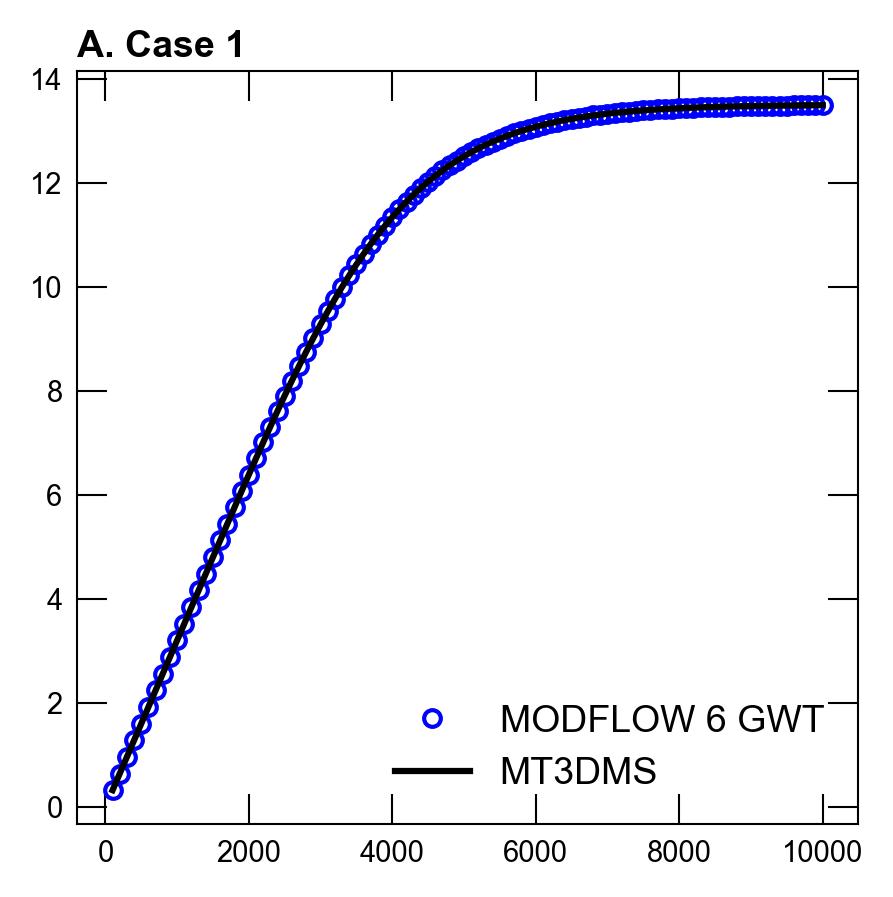

Building mf6gwf model...ex-gwt-mt3dsupp632b
Building mf6gwt model...ex-gwt-mt3dsupp632b
Building mf2005 model...ex-gwt-mt3dsupp632b
Building mt3dms model...ex-gwt-mt3dsupp632b


run_models took 111.62 ms


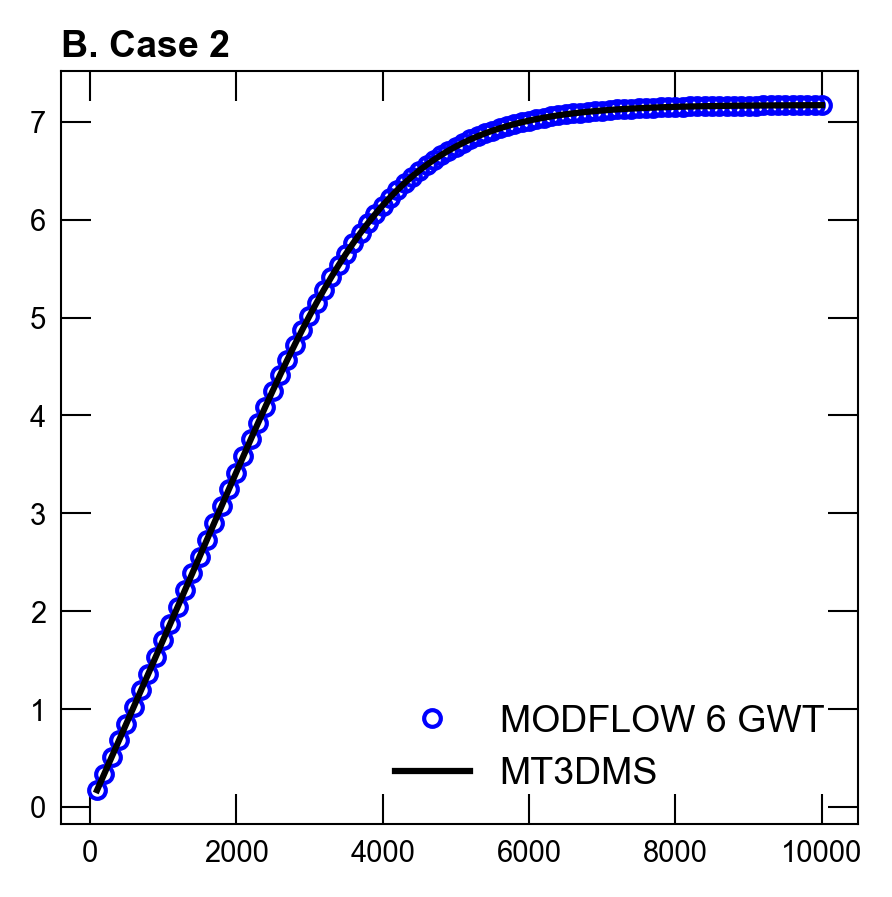

Building mf6gwf model...ex-gwt-mt3dsupp632c
Building mf6gwt model...ex-gwt-mt3dsupp632c
Building mf2005 model...ex-gwt-mt3dsupp632c
Building mt3dms model...ex-gwt-mt3dsupp632c
run_models took 98.06 ms


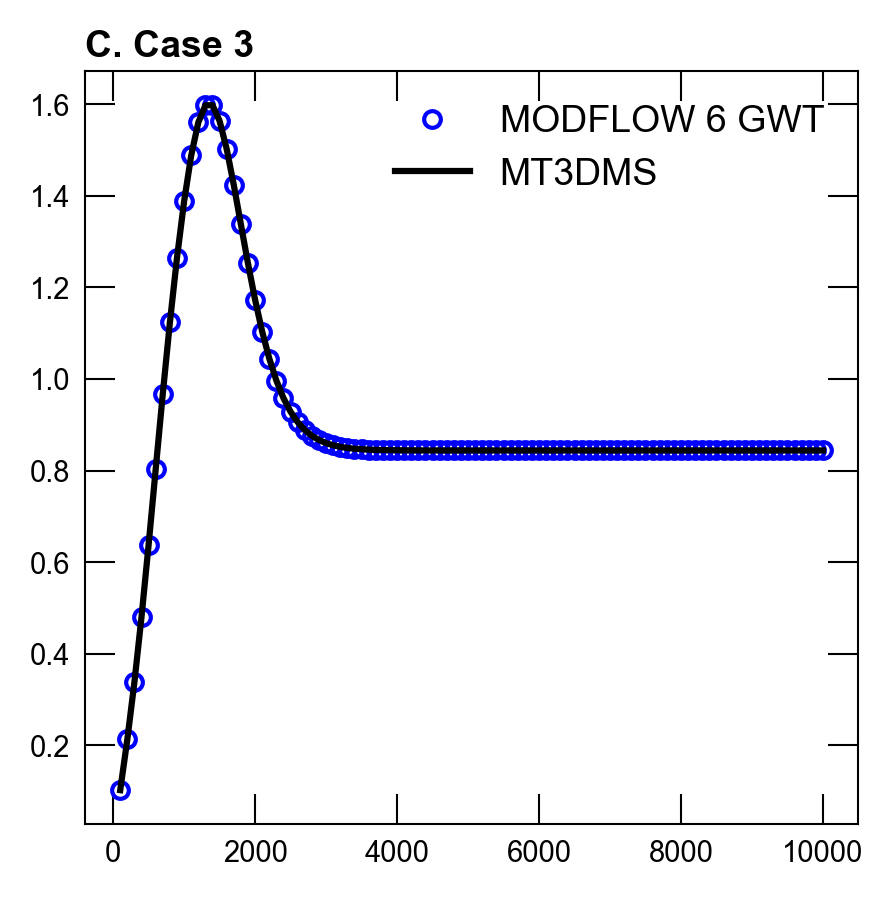

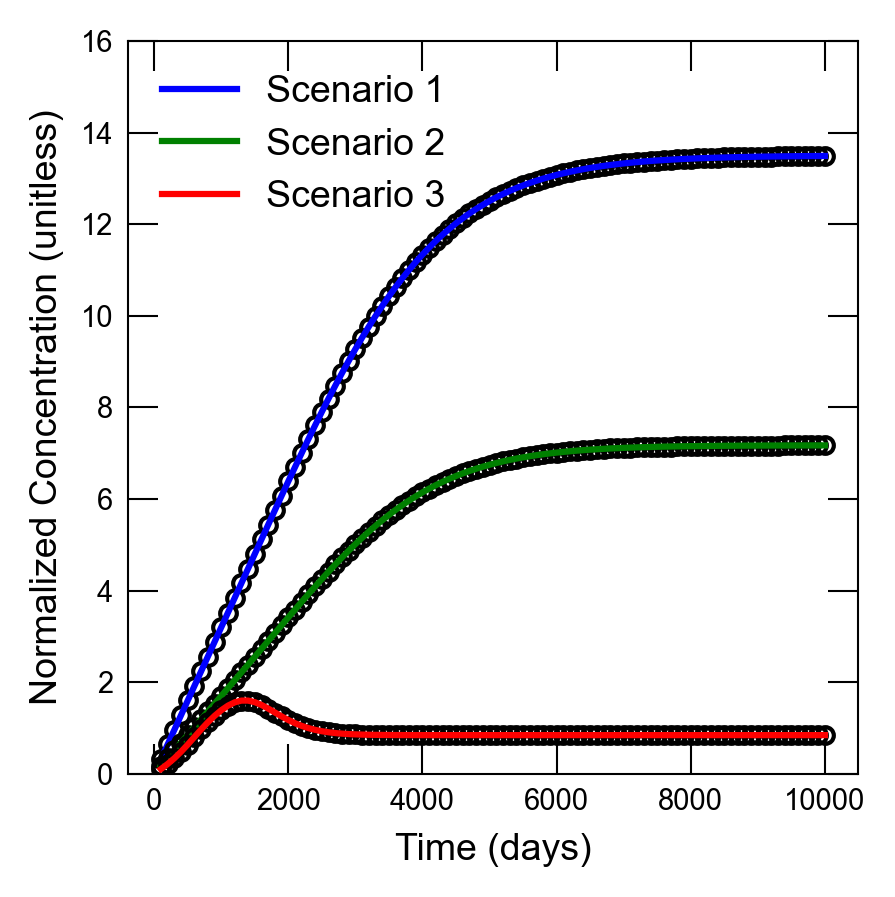

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    sims = build_models(key, **parameter_dict)
    if write:
        write_models(sims, silent=silent)
    if run:
        run_models(sims, silent=silent)
    if plot:
        plot_scenario_results(sims, idx)


# ### Case 1
#
# ex-gwt-mt3dsupp632a
# * distribution_coefficient = 0.25
# * decay = 0.0
# * decay_sorbed = -1.0e-3

scenario(0)

# ### Case 2
#
# ex-gwt-mt3dsupp632a
# * distribution_coefficient = 0.25
# * decay = -5.e-4
# * decay_sorbed = -5.e-4

scenario(1)

# ### Case 3
#
# ex-gwt-mt3dsupp632a
# * distribution_coefficient = 0.
# * decay = -1.0e-3
# * decay_sorbed = 0.

scenario(2)

# Plot the results for all 3 scenarios in one plot.

if plot:
    plot_results()